# Fourier Transform in Medical Imaging

## Introduction


The Fourier Transform is one of the most powerful and well known tools to analyse frequency behaviour. As such, it allows performing many operations in signal and imaging processing. In particular for imaging, it can be used for image formation,  filtering, evaluation, characterization, among other applications.

In particular for medical imaging applications some of the most widespread applications of Fourier Transform are:
1. Formation of Magnetic Resonance Images since the acquisition of signals is made in the frequency domain
2. Backprojection algorithms necessary to form tomography images work in the frequency domain (i.e. SPECT, CT, PET)
3. Calculation of blood velocity from ultrasound Doppler since it is related to shift in frequency of the signal

In addition, other applications for images or signals related to images require the Fourier Transform:
1. Filtering signals used before image formation to reduce noise 
2. Image compression based on filtering certain frequency components
3. Image sharpening based on enhancing certain frequency components

Fourier transforms present important properties that allow to combine analysis in frequency with simplicity:
1. Linearity: the transform of a sum is the sum of the transforms
2. Symmetry: the transform of the negative frequency is the conjugate of the transform
3. Convolution: the transform of a convolution is the product of each transform

In addition, filter design often requires analysing the frequency response:
1. It is often necessary to understand the behaviour of your signal before proposing the design of a filter
2. Once a filter is chosen, the impact of the order on the frequency behaviour of the filter and how that may affect the signal is important

The Discrete Fourier Transform (DFT) is the primary analysis tool for Fourier Transform nowadays since much of the processing is performed on digitized signals.

Using the DFT is equivalent to obtain a periodic signal out of a sequence (samples) of values.

## Signal for Image Formation

This notebook will __first__ show how the DFT is implemented on a signal:
* How we can detect the presence and main frequency components of noise within the signal
* How we can determine the main frequency of the signal of interest

We will work on an __ultrasound signal__ that was acquired to form a single line of the image. The signal from the same line was acquired multiple times but at some point noise appeared on the signal. We will analyse the frequency components of this line and we will determine when noise appears as well as the frequency component of the noise and the signal.

The signal is provided in a binary file for which the following information is known:
* It has 15,000 samples 
* The sampling frequency was 125MHz (one sample every 8ns)
* This line was acquired a total of 462 times
* Each sample was saved as an unsigned integer (16 bits)
* The file size is then 15,000 x 462 x 16 = 13,860,000 Bytes (13.86 MBytes)

## Image Frequency Domain

We will now work on a standard medical image from MRI and obtain the frequency components of an image, which we will then plot. And then, we will eliminate high and low frequency components and replot the image to understand where the information on an image is from the frequency standpoint.


# Signal - First Step

We will start by opening the file and plotting the first line acquired


 The length of the file is: 6930000 as expected from 15,000 samples x 462 lines

 The length of the time array is: 15000


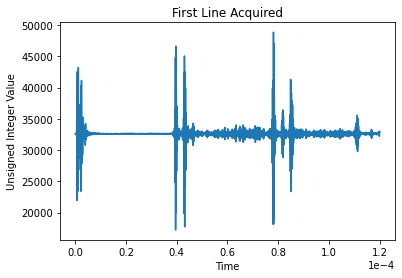

In [4]:
%matplotlib inline
# This is a magic command that initialize the matplotlib library for plotting inline with this notebook, 
# otherwise the plots will open in a second window which then does not allow for visualization as a notebook

# We need to import different packages that will allow to do math, lineal algebra, numerical operations,
# array operations and plotting
import scipy as Sci
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt

# Lets use variables for parameters (frequency and total samples)
fs=125e6
TSamples=15000

# We use an open command for the file, since Azure Notebooks works on Linux, be sure to respect capitalizaed names !!!
f = open('Source Files/UltrasoundSampleSignal.dat','rb') #make sure your data is on the same folder as your .ipynb file
# We read the file using a numpy (therefore the np.) command that allows directly reading from file into an array
# The -1 ensures the whole file is read, uint16 since it is known to be the data format of the file
AllSignal = np.fromfile(f,count=-1,dtype=np.uint16)  
# To verify the size of the file we print here the lenght of the array 
print('\n The length of the file is: ' + str(len(AllSignal)) + ' as expected from 15,000 samples x 462 lines')
# We will now create an array for the time which we now is 1/125MHz step for a total of 15,000 samples
# Arange(X,Y,S) creates an array from value X to value Y with an S step therefore from 0 to 15,000 x 8 ns step=8 ns
time=np.arange(0,TSamples/fs,1/fs)  #start,stop,step
print('\n The length of the time array is: ' + str(len(time)) )
# We will now arrange that linear array into a 2D array where each row is an acquired line
NLines = int(len(AllSignal)/TSamples)   # We already now it should be 462 but this will calculate it anyway
SignalArray = np.reshape(AllSignal,(NLines,-1))   #The -1 in reshape makes the lenght of each row be inferred
# We plot the first line acquired   
plt.plot(time,SignalArray[1,:])
plt.title('First Line Acquired')
plt.xlabel('Time')
plt.ylabel('Unsigned Integer Value')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
f.close() #close the file

### Activity 1 - Copy the code above into the cell below and plot a different line, see if you can find a line where there is visible noise. Add an appropriate title to this noisy line.

In [6]:
# Add the code that plots a noisy line acquired   

# HERE

# Signal - All lines plotted together

We will now plot all lines together and we will clearly see the noise in some signals. __Note__ this may be slow.

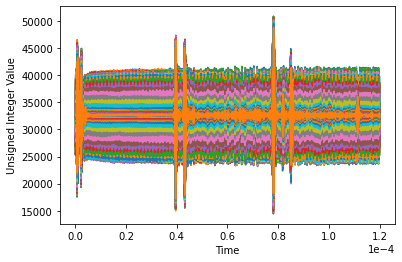

In [7]:
# We can plot all lines by using a for and keep plotting on the same output
totlines=np.arange(NLines)
# the for requires an variable to count (here called index) and will each time change the value of this index
# to the "next" value in the array after in (here totlines)
for index in totlines:    
    plt.plot(time,SignalArray[index,:])
    plt.xlabel('Time')
    plt.ylabel('Unsigned Integer Value')
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

# Add the code for a title to the plot

# HERE

### Activity 2 - Add a title to the plot above.

# Signal - Frequency Spectrum

We can see from above that there are some lines that have noise. You may even "find" your signal from before.

We will first analyse the frequency component of a clean and a noisy line. You can already change the code before running to use the same line that you plotted before. Here I have chosen line 174.

we will obtain the frequency component of those two signals using DFT.

First lets define the DFT:

$$ A_k=\frac{1}{\sqrt{N}} \sum_{n=0}^{N-1}a_n \exp \left(-2\pi i \frac{nk}{N} \right ) [k=0,...,N-1] $$

We will then obtain the DFT.

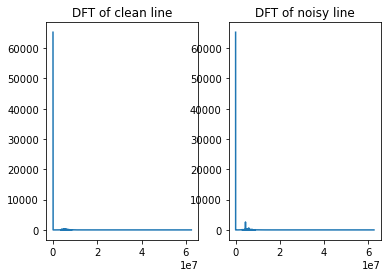

In [8]:
# First let's determine the frequency axis for the spectrum based on the sampling from dc (0) to half of the sampling frequency
freq=np.arange(0,fs/2,fs/TSamples)  # again arange will do an array from 0 to 125MHz/2 with a step of 125MHz/Total Samples
# We use fft function in numpy
SignalFFT=np.fft.fft(SignalArray)
# And this is a complex number, the spectrum is defined as the magnitude
SignalFFTMag=abs(SignalFFT)*2/TSamples    # Note that numpy fft is NOT normalized, so we need to do so *2/N N=number of samples

# We plot now two spectrums side by side: the clean line 1 and the noisy line 174
plt.subplot(121)
plt.plot(freq, SignalFFTMag[1,:int(TSamples/2)])   #Ploting just half, the other half will be a mirror image
plt.title('DFT of clean line')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.subplot(122)
plt.plot(freq, SignalFFTMag[174,:int(TSamples/2)])
plt.title('DFT of noisy line')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

We notice the signal has a __large__ dc component (frequency of zero, which means the signal is not centered in zero as you can verify from your initial plots).

This is shadowing the spectrom so we can first remove the dc component. A simple way to do this is substracting the mean of the data. We will do this and repeat the spectrum.

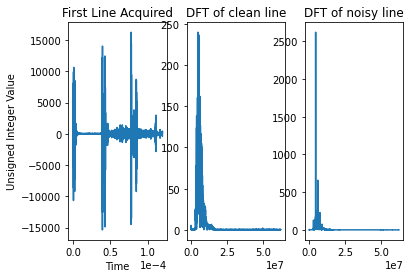

In [9]:
# We first eliminate dc
SignalArray=SignalArray-np.mean(SignalArray)

# Let's replot that first line and see it is now centered at zero
plt.subplot(131)
plt.plot(time,SignalArray[1,:])
plt.title('First Line Acquired')
plt.xlabel('Time')
plt.ylabel('Unsigned Integer Value')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

# And recalculate the DFT
SignalFFT=np.fft.fft(SignalArray)
SignalFFTMag=abs(SignalFFT)*2/TSamples    # Note that numpy fft is NOT normalized, so we need to do so *2/N N=number of samples

# Plot again the two spectrums side by side: the clean line 1 and the noisy line 174
plt.subplot(132)
plt.plot(freq, SignalFFTMag[1,:int(TSamples/2)])
plt.title('DFT of clean line')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.subplot(133)
plt.plot(freq, SignalFFTMag[174,:int(TSamples/2)])
plt.title('DFT of noisy line')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

We can clearly see there are large noise peaks at various frequencies. The noisy line has 10X higher amplitudes at some frequencies compared to the clean line. It will help to zoom into this noisy and clean spectrum.

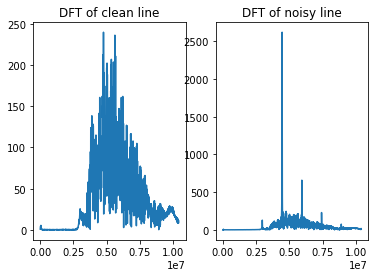

In [10]:
# Plot zoom of two spectrums side by side: the clean line 1 and the noisy line 174
plt.subplot(121)
plt.plot(freq[:1250], SignalFFTMag[1,:1250])
plt.title('DFT of clean line')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.subplot(122)
plt.plot(freq[:1250], SignalFFTMag[174,:1250])
plt.title('DFT of noisy line')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

Now we can see that the noise peaks are actually harmonics and there is a strong component at 4.5MHz.

### Activity 3 - Use interactive plot tool and "see" where those peaks are. This will require matplotlib backend  *nbagg*. Go up in the code and change the magic command ```%matplotlib inline``` for ```%matplotlib nbagg``` and you will now be in **interactive mode**.

**BEFORE YOU RUN** select the option "Kernel->Restart" or the rendering will fail. Or close and reopen the notebook.

 **Write here the value for the peaks:**

 **HERE**


## Image - Rendering

We will now obtain the spectrum of an image using the DFT.

First, we need to render the image and we will work with an MR image that was saved as a PNG file.

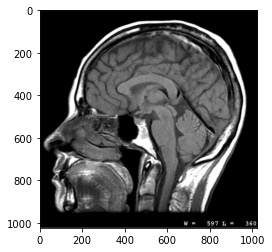

In [12]:
# Importing PIL library for using the image as an array
from PIL import Image

# Reading the PNG file as a grayscale
image = Image.open('Source Files/BrainComplete.png').convert("L")
# The array arr will have the image as an array
arr = np.asarray(image)
# We need to use imshow specifying that it is a grayscale or it will be rendered as colour
#plt.imshow(arr, cmap='gray')
plt.imshow(arr, plt.cm.gray)

Tlines=np.shape(image)[1]
Trows=np.shape(image)[1]

# Add the code to hide the tick values
# HERE

### Activity 4 - Hide the tick values on the axes 

## Image - DFT 

The DFT of an image is the 2D DFT for the array (image):

$$ A_{k_1,k_2}=\frac{1}{\sqrt{MN}}\sum_{m=0}^{M-1} \sum_{n=0}^{N-1}a_{m,n} \exp \left [-2\pi i \left(\frac{mk_1}{M}+\frac{nk_2}{N}\right) \right ] [k_1,k_2=0,...,n-1] $$

Text(0.5, 1.0, 'Image FFT - Shifted')

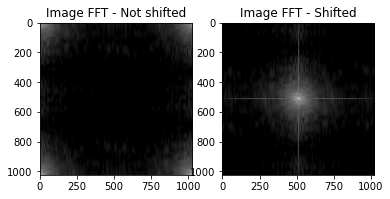

In [13]:
# This DFT will be too large for visualization so we will need to normalize logarithmically so we import
from matplotlib.colors import LogNorm

# We use fft2 function in numpy for the 2D DFT
ImageFFT=np.fft.fft2(arr)

# And this is a complex number so we obtain the magnitude and we divide by the total number of samples
ImageFFTMag=abs(ImageFFT)*2/Tlines*2/Trows    # Note that fft is now normalized by 2/N and 2/M with an image NxM

# The 2D FFT, just as the 1D is repeated in 2 dimensions, if we want to see an image we need to shift it
ImageFFTMagShift=np.fft.fftshift(ImageFFTMag)

# This is the non shifted FFT
plt.subplot(121)
plt.imshow(ImageFFTMag, cmap='gray', norm=LogNorm(vmin=1e-2))
plt.title('Image FFT - Not shifted')

# And the shifted FFT (note the repeats)
plt.subplot(122)
plt.imshow(ImageFFTMagShift, cmap='gray', norm=LogNorm(vmin=1e-2))
plt.title('Image FFT - Shifted')

There is clearly a *concentration* of information at the *central* frequencies of the image:

* This means that if we eliminated those, the impact will be high on the resulting image
* Also, that we may still have an interpretable image if we eliminated the non central frequencies
* What is in these *central* frequencies? Let's eliminate them and do the inverse DFT to get an image

# Inverse DFT - Image back
First we make sure we can get the image back by doing the inverst DFT

Text(0.5, 1.0, 'Image after Inverse FFT')

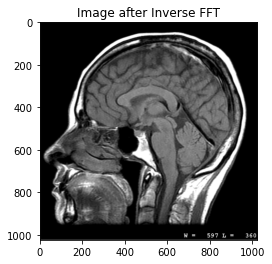

In [14]:
ImageBack=np.fft.ifft2(ImageFFT)
plt.imshow(np.abs(ImageBack),cmap='gray')
plt.title('Image after Inverse FFT')

# Frequencies at the centre of the spectrum in the image
We can now eliminate the frequencies at the *centre of the spectrum* (found in the four corners of a non-shifted 2D DFT) and see how this image is reconstructed

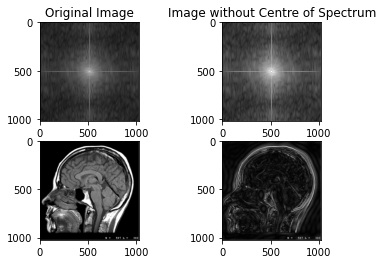

In [15]:
# We will eliminate NN elements on each corner, you define NN, I suggest to start with 8 and keep going up
NN=10

ImageFFTCF=np.copy(ImageFFT)
ImageMask=np.ones([Tlines,Trows])
ImageMask[0:NN,0:NN]=0
ImageMask[Tlines-NN:Tlines,Trows-NN:Trows]=0
ImageMask[0:NN,Trows-NN:Trows]=0
ImageMask[Tlines-NN:Trows,0:NN]=0

ImageFFTCF=ImageFFTCF*ImageMask

# And this is a complex number so we obtain the magnitude and we divide by the total number of samples
ImageFFTMag=abs(ImageFFT)*2/1024*2/1024    # Note that fft is now normalized by 2/N and 2/M with an image NxM
ImageFFTMagCF=abs(ImageFFTCF)*2/1024*2/1024    # Note that fft is now normalized by 2/N and 2/M with an image NxM

# This is the shifted original FFT
ImageFFTMagShift=np.fft.fftshift(ImageFFTMag)
plt.subplot(221)
plt.imshow(ImageFFTMagShift, cmap='gray', norm=LogNorm(vmin=1e-3))
plt.title('Original Image')

# This is the shifted FFT
ImageFFTMagCFShift=np.fft.fftshift(ImageFFTMagCF)
plt.subplot(222)
plt.imshow(ImageFFTMagCFShift, cmap='gray', norm=LogNorm(vmin=1e-3))
plt.title('Image without Centre of Spectrum')

plt.subplot(223)
ImageBack=np.fft.ifft2(ImageFFT)
plt.imshow(np.abs(ImageBack),cmap='gray')

plt.subplot(224)
ImageBackHF=np.fft.ifft2(ImageFFTCF)
plt.imshow(np.abs(ImageBackHF),cmap='gray')

The __frequencies at the centre__, as it can be seen, contain the majority of the image information. If we eliminate them much of the image is lost and we only keep the edges of the image.

__Edges__ mean *rapid* changes in information (goes from nothing to white or vice-versa).

## Activity 5 - Answer this question in this markdown with text in **red**: are the frequencies in the centre of the spectrum high or low? Explain in your own words why.

 **Add here the markdown content with your answer to the question, the text should be in red colour**


## Summary

In this example:

1. We executed the Discrete Fourier Transform (DFT) on a clear and noisy signal
2. We executed and analyzed the Discrete Fourier Transform (DFT) on an image
3. We determined the frequency content of an image and what parts are associated with edges

## Assignment 1

* Complete the 5 Activities in the notebook and commit your notebook to your GitHub repository.
* Remember you should have given permissions to this **private** repository to your instructor.
* Please note you should upload all your code in the repository with those permissions, do not give permissions every time for new repositories.
* Submit on D2L the PDF of your notebook where the results of these activities can be seen. The backup PDF accounts for 10% of your mark. Note that full marks are only given if the code is on your repository and runs, but you can get partial marks from this PDF output if the code fails to run or is not accessible at the time of grading. No marks will be given if the date on GitHub is after the deadline.
* The following challenges **are for bonus points** and you can submit them later (up until the final exam date) 

# Challenge \#1 - Signal

For the signal, since you can see the noise happens at a high threshold, try to create a loop that will list the lines that have noise.

To find which line(s) in the acquisition have a noticeable noise (as defined by the spectrum having an amplitude in the FFT higher than the maximum value found in the clean line x 10)

    1. Display all the line numbers that fall under this criteria
    2. Display the amplitude of the highest peak for each noisy line
    
Tip: you can use the np.max() or np.amax() functions to find the maximum value in an array (the second one through a specific axis should allow for a code without a loop!

In [ ]:
# Enter your Challenge code HERE


# Challenge \#2 - Signal

Once you have the lines that are noisy, produce a plot that shows the threshold line and which lines/values went above to check your result.

In [ ]:
# Enter your Challenge code HERE


# Challenge \#3 - Image

For the image:

* Try now eliminating the non-central frequencies (reuse the code but create a new cell)
* Graph your result

And answer:

* What information are you loosing when those frequencies are eliminated?
* Are those frequencies high or low?
* What do you think this can be used for? 
* Would you be able to eliminate high or low frequencies in a medical image without consequences?
* If you needed to eliminate either high or low frequencies while transmitting an image, which would you go for to keep diagnostic power (tip: it is contrast that matters most)
* What else other than the technique shown here could you use to eliminate "low" or "high" frequencies in an image? (No need to code and run, just mention and give the name of the Python function you may use)

In [ ]:
# Enter your Challenge code HERE


References
---------------

* Smith, Nadine Barrie, and Andrew Webb. Introduction to medical imaging: physics, engineering and clinical applications. Cambridge university press, 2010.